In [1]:
# Import required packages
import pickle
from pathlib import Path
from collections import defaultdict
from itertools import cycle, permutations
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Prepare working capacity database from raw GCMC database 
# Working capacity was calculated between 100 bar and 5 bar)

pressures = [
  1,2,5,10,20,30,35,40,50,60,70,80,90,100
]

names = ["key"] + [str(p) for p in pressures]

uptake_data_paths = [
    "cycle_tot.txt",
]

wc_data_list = []
for path in uptake_data_paths:
    data = pd.read_table(path, index_col=0, header=None, names=names, sep="\s+")
    data = data["100"] - data["5"]
    wc_data_list.append(data)
wc_data = pd.concat(wc_data_list)


print("total number of data is %d" % len(wc_data)) 

total number of data is 132209


In [3]:
# Normalize working capacity. Scale working capacity into [0,1]
data = wc_data.copy() / 100.0

In [4]:
#Import MOFNet (ACS Appl. Mater. Interfaces 2021, 13, 20, 23647–23654)
from mofnet import DataLoader, MOFNet


mofnet = MOFNet()
mofnet.initialize_weights()


In [5]:
# Load trained MOFNet for hydrogen working capacity prediction

mofnet.load_weights("mofnet-cycle_tot-min.h5")

In [6]:
# Extract test dataset for the prediction (fraction ; percentage of data to sample)

fraction = 0.1
test_data = data.sample(frac=fraction)

test_data.describe()

count    13221.000000
mean         0.290802
std          0.085819
min          0.000000
25%          0.271458
50%          0.320687
75%          0.346712
max          0.399487
dtype: float64

In [7]:
# Load test data to data loader

data_loader = DataLoader.from_state("data_loader_state-20200116.npz")

test_set = data_loader.make_dataset(np.array(test_data.index, dtype=str),np.array(test_data),batch_size=1000,repeat = False, shuffle = False)

In [8]:
# Make prediction
y_pred = []
for x, y in test_set:
    _y = mofnet(x)
    y_pred += _y.numpy().reshape(-1).tolist()
y_pred = np.array(y_pred)

In [9]:
# Rescale

x = test_data*100
y = np.array(y_pred)*100

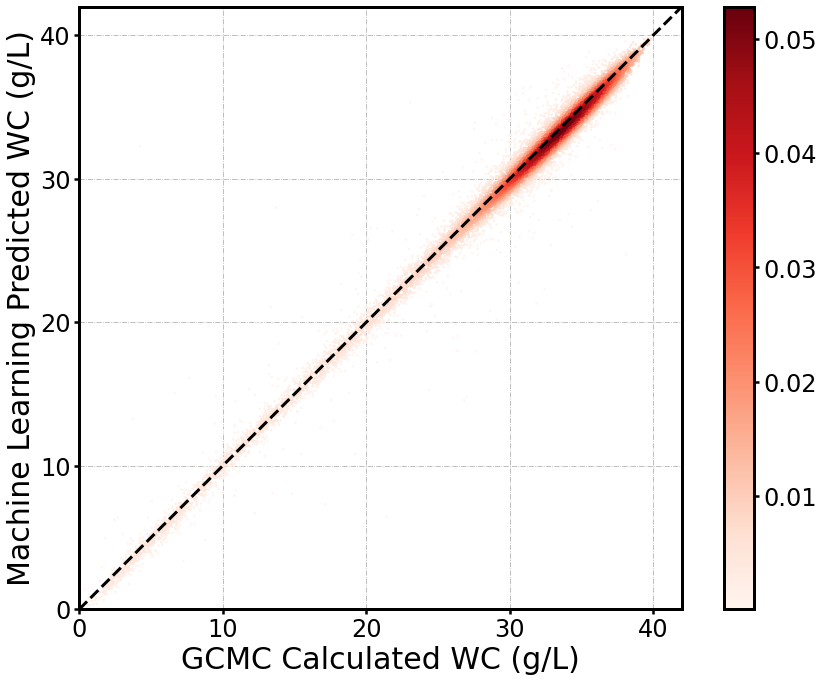

In [10]:
#Draw parity plot

plt.rcParams['font.size']=24
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2.5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2.5
mpl.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.axisbelow'] = True

fig, ax = plt.subplots(1,1, figsize=(13, 10))

T = np.array([x, y])
color = gaussian_kde(T)(T)

im = plt.scatter(x,y, c=color, cmap='Reds',s=2)
ax.set_aspect('equal')

plt.plot([0, 42], [0, 42], c="black", linewidth=3, linestyle='--')
plt.colorbar(im)

plt.yticks([0,10,20,30,40],fontsize=24)
plt.xticks([0,10,20,30,40], fontsize=24)

plt.tick_params(axis='both', labelsize=24)

plt.tick_params(labelsize=24)

plt.xlabel('GCMC Calculated WC (g/L)', fontsize = 30)
plt.ylabel('Machine Learning Predicted WC (g/L)', fontsize = 30)

plt.grid(axis='both',linestyle='-.')

plt.xlim(xmin=0,xmax=42)
plt.ylim(ymin=0,ymax=42)

plt.tight_layout()
